In [1]:
!pip install feedparser
!pip install textstat
!pip install vaderSentiment
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import feedparser
import textstat
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.stats import ttest_ind
from wordcloud import WordCloud, STOPWORDS
import warnings
import os, glob
from bs4 import BeautifulSoup

warnings.filterwarnings("ignore")

liar_path = '/kaggle/input/liardataset/archive (1)/train.tsv'

try:
    df_liar = pd.read_csv(liar_path, sep='\t', header=None, usecols=[1, 2])
    df_liar.columns = ['label', 'text']
    label_map = {
        'true': 'REAL', 'mostly-true': 'REAL', 'half-true': 'REAL',
        'false': 'FAKE', 'pants-fire': 'FAKE', 'barely-true': 'FAKE'
    }
    df_liar['label'] = df_liar['label'].map(label_map)
    df_liar = df_liar.dropna()
    df_liar['language'] = 'en'
    df_liar['source'] = 'LIAR_Dataset'
    print("LIAR yüklendi:", len(df_liar))
except Exception as e:
    print("Hata:", e)
    df_liar = pd.DataFrame()


real_path_tr = '/kaggle/input/turkishdata/TurkishFakeNewsDataset-master/Clean/Real'
fake_path_tr = '/kaggle/input/turkishdata/TurkishFakeNewsDataset-master/Clean/Fake'

def load_tr_data(path, label):
    texts = []
    if os.path.exists(path):
        for file in glob.glob(os.path.join(path, '*')):
            try:
                with open(file, 'r', encoding='utf-8') as f:
                    texts.append(f.read())
            except:
                continue
    return pd.DataFrame({'text': texts, 'label': label})


df_tr = pd.concat([
    load_tr_data(real_path_tr, 'REAL'),
    load_tr_data(fake_path_tr, 'FAKE')
])
df_tr['language'] = 'tr'
df_tr['source'] = 'Turkish_Dataset'
print("Türkçe veri:", len(df_tr))


reddits = {
    'REAL': [
        'https://www.reddit.com/r/worldnews/.rss',
        'https://www.reddit.com/r/europe/.rss',
        'https://www.reddit.com/r/Turkey/.rss'
    ],
    'FAKE': [
        'https://www.reddit.com/r/conspiracy/.rss',
        'https://www.reddit.com/r/Fakeddit/.rss'
    ]
}

reddit_texts = []

for label, urls in reddits.items():
    for u in urls:
        try:
            feed = feedparser.parse(u)
            for e in feed.entries:
                content = getattr(e, 'summary', '')
                text = BeautifulSoup(content, 'html.parser').get_text()
                if len(text) > 20:
                    reddit_texts.append({
                        'text': text,
                        'label': label,
                        'language': 'en',
                        'source': 'Reddit_RSS'
                    })
        except:
            continue


df_reddit = pd.DataFrame(reddit_texts)
print("Reddit verisi:", len(df_reddit))

df_master = pd.concat([df_liar, df_tr, df_reddit], ignore_index=True)
df_master = df_master.sample(frac=1, random_state=42).reset_index(drop=True)

print("TOPLAM VERİ:", len(df_master))


def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+','', text)
    text = re.sub(r'@\w+','', text)
    text = re.sub(r'#','', text)
    text = re.sub(r'[^a-zA-ZçÇğĞıİöÖşŞüÜ\s\.!?]', '', text)
    return text.strip()

df_master['cleaned_text'] = df_master['text'].apply(clean_text)
df_master['word_count'] = df_master['cleaned_text'].apply(lambda x: len(str(x).split()))


def get_caps_ratio(text):
    letters = [c for c in str(text) if c.isalpha()]
    return sum(1 for c in letters if c.isupper()) / len(letters) if letters else 0

df_master['caps_ratio'] = df_master['text'].apply(get_caps_ratio)


clickbait_words = ['shocking','skandal','inanılmaz','breaking','flaş','secret','gizli','leaked']
df_master['clickbait_score'] = df_master['text'].apply(
    
    lambda x: sum(1 for w in clickbait_words if w in str(x).lower())
)


vader = SentimentIntensityAnalyzer()

def get_sentiment(row):
    text = row['cleaned_text']
    if row['language'] == 'en':
        return vader.polarity_scores(text)['compound']
    else:
        return TextBlob(text).sentiment.polarity

df_master['sentiment_score'] = df_master.apply(get_sentiment, axis=1)

print("Özellik mühendisliği tamamlandı.")


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 5.2 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=3c97787bf263b2715d3bc3ae08c040c2a3403a87b1292b3ad44724b69e480c98
  Stored in directory: /root/.cache/pip/wheels/3b/25/2a/105d6a15df6914f4d15047691c6c28f9052cc1173e40285d03
Successfully built sgmllib3k
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.8 MB/s eta 0:00:00
LIAR yüklendi: 10240
Türkçe veri: 4459
Reddit verisi: 101
TOPLAM VERİ: 14800
Özellik mühendisliği tamamlandı.


In [2]:
vader = SentimentIntensityAnalyzer()

def get_sentiment(row):
    text = row['cleaned_text']
    if row['language'] == 'en':
        return vader.polarity_scores(text)['compound'] 
    else:
        return TextBlob(text).sentiment.polarity 

df_master['sentiment_score'] = df_master.apply(get_sentiment, axis=1)

print("Özellik mühendisliği tamamlandı.")

Özellik mühendisliği tamamlandı.



--- Ortalama Değerler (REAL vs FAKE) ---
       word_count  caps_ratio  sentiment_score  clickbait_score
label                                                          
FAKE   131.367081    0.033605         0.008483         0.034596
REAL    71.026837    0.031077        -0.007288         0.017112


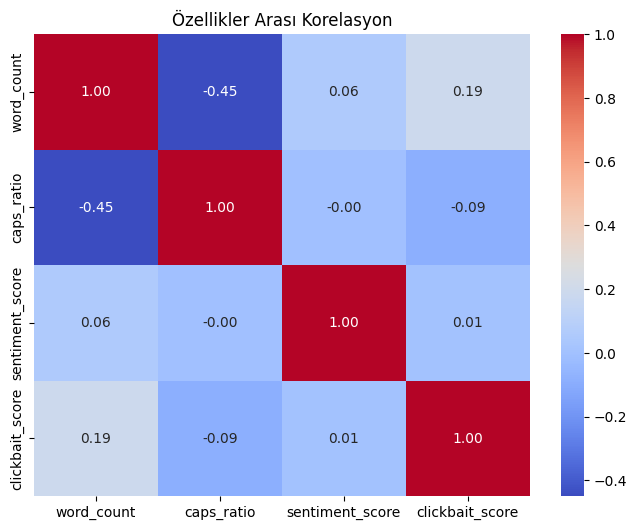


--- Hipotez Testi Sonucu ---
P-Değeri: 0.00001
SONUÇ: Fake ve Real haberler arasında büyük harf kullanımında İSTATİSTİKSEL OLARAK ANLAMLI fark var.


In [3]:
print("\n--- Ortalama Değerler (REAL vs FAKE) ---")
summary = df_master.groupby('label')[['word_count', 'caps_ratio', 'sentiment_score', 'clickbait_score']].mean()
print(summary)

plt.figure(figsize=(8, 6))
corr = df_master[['word_count', 'caps_ratio', 'sentiment_score', 'clickbait_score']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Özellikler Arası Korelasyon")
plt.show()

# "Fake haberler, Real haberlerden daha fazla büyük harf kullanır mı?"
real_caps = df_master[df_master['label'] == 'REAL']['caps_ratio']
fake_caps = df_master[df_master['label'] == 'FAKE']['caps_ratio']

t_stat, p_val = ttest_ind(real_caps, fake_caps, equal_var=False)

print("\n--- Hipotez Testi Sonucu ---")
print(f"P-Değeri: {p_val:.5f}")
if p_val < 0.05:
    print("SONUÇ: Fake ve Real haberler arasında büyük harf kullanımında İSTATİSTİKSEL OLARAK ANLAMLI fark var.")
else:
    print("SONUÇ: Anlamlı fark yok.")


 1. Veri Kalitesi Kontrolü
Eksik Veri Sayısı:
label              0
text               0
language           0
source             0
cleaned_text       0
word_count         0
caps_ratio         0
clickbait_score    0
sentiment_score    0
dtype: int64

Tekrar Eden Satır Sayısı: 28

Sınıf Dağılımı (Balance):
label
REAL    0.548851
FAKE    0.451149
Name: proportion, dtype: float64


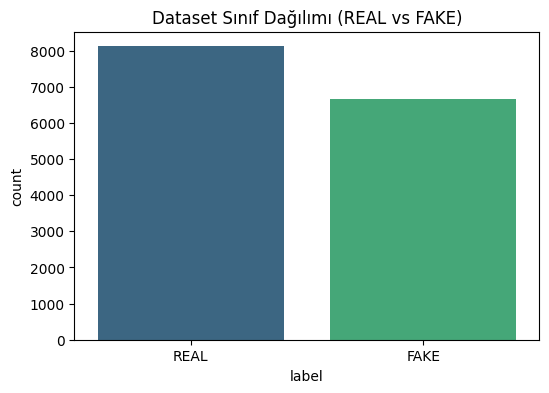


Temizlik Öncesi Toplam Satır: 14800
Temizlik Sonrası Toplam Satır: 14772
28 adet kopya (duplicate) veri temizlendi.

Yeni Sınıf Dağılımı:
label
REAL    0.548741
FAKE    0.451259
Name: proportion, dtype: float64

 3. Kelime Bulutu Analizi


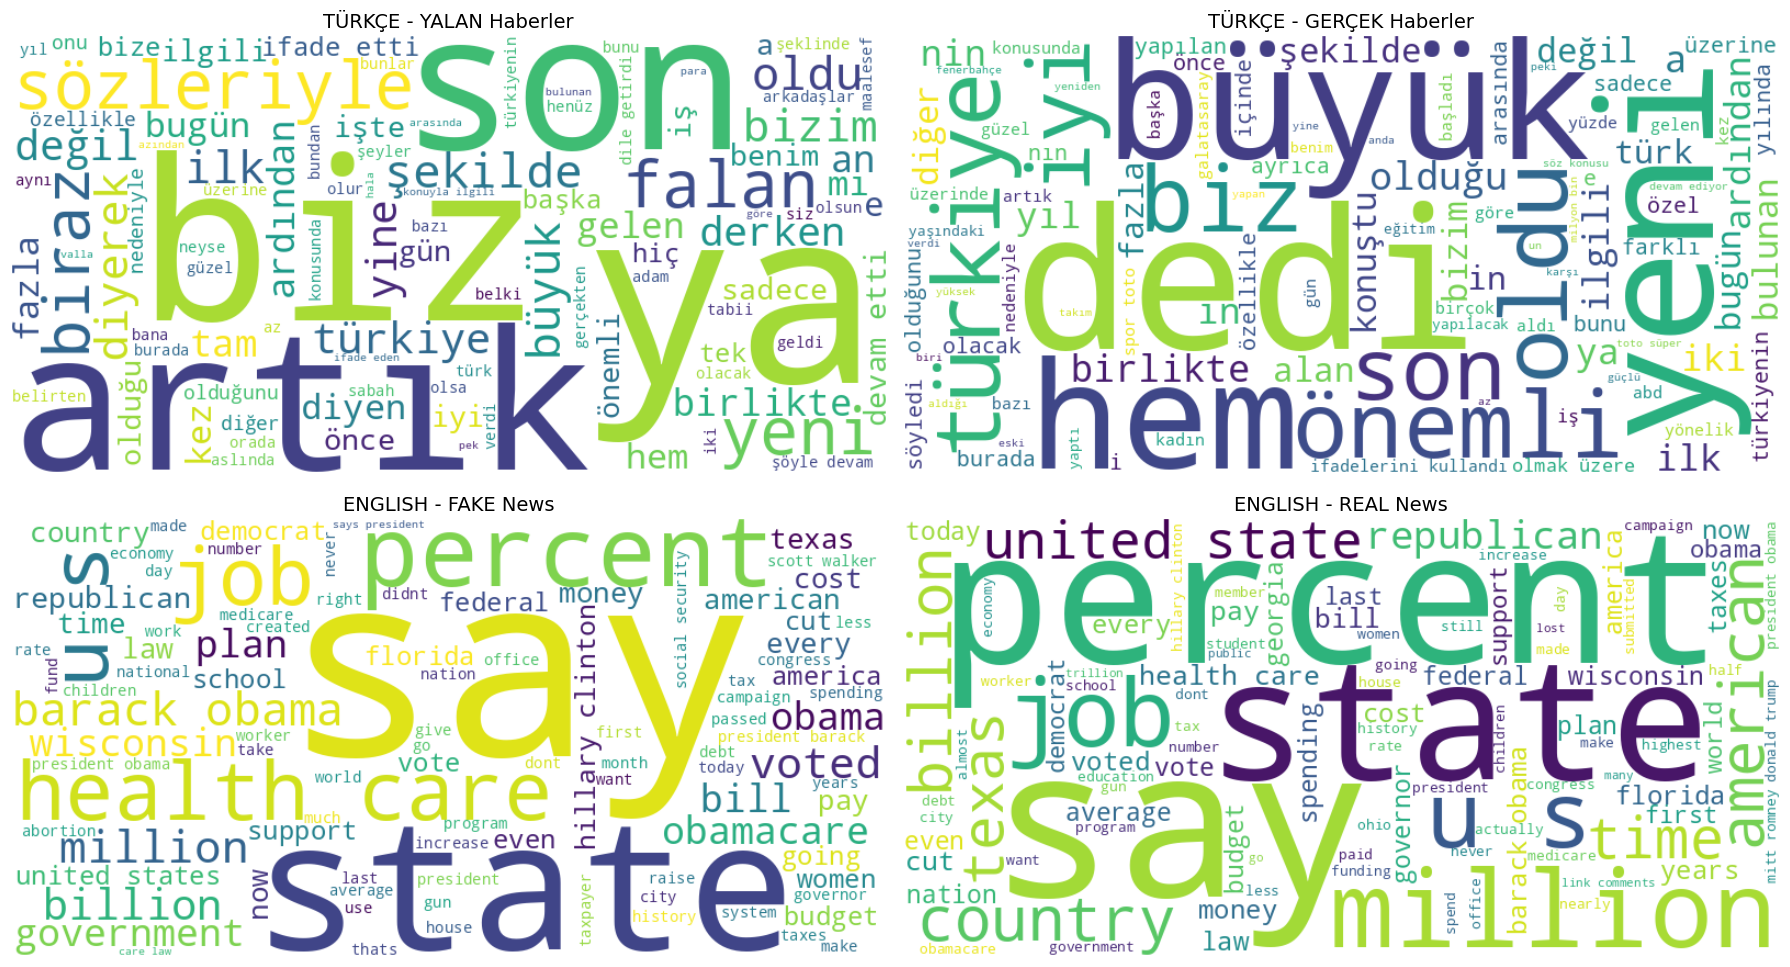


 4. Özellik Dağılım Analizi (KDE)


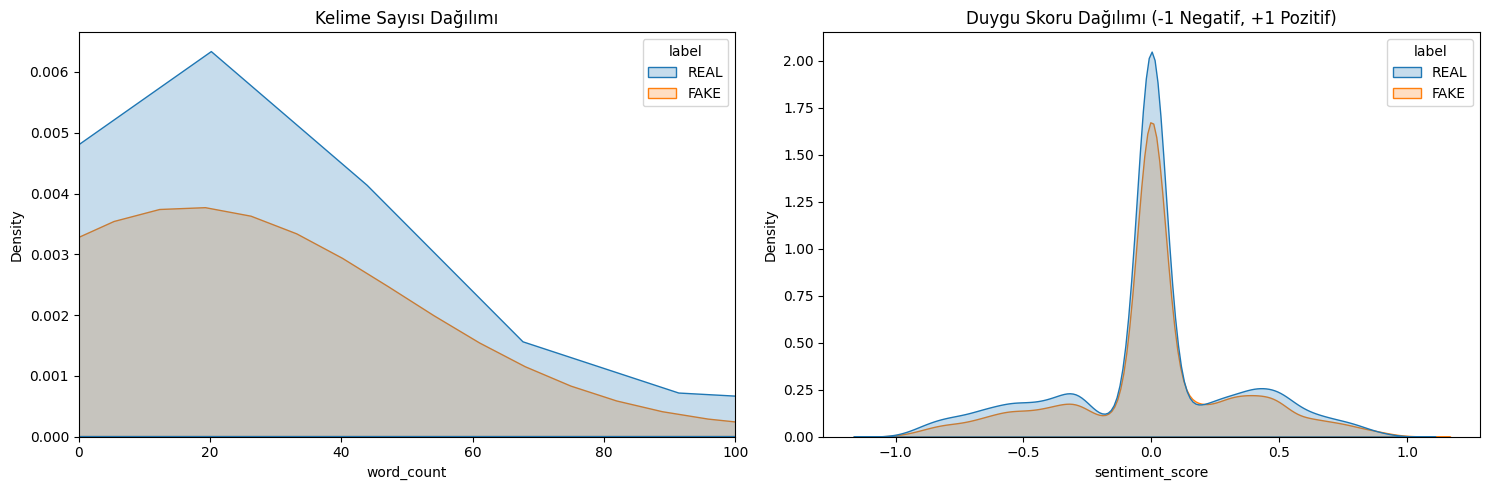


 5. N-Gram (İkili Kelime) Analizi


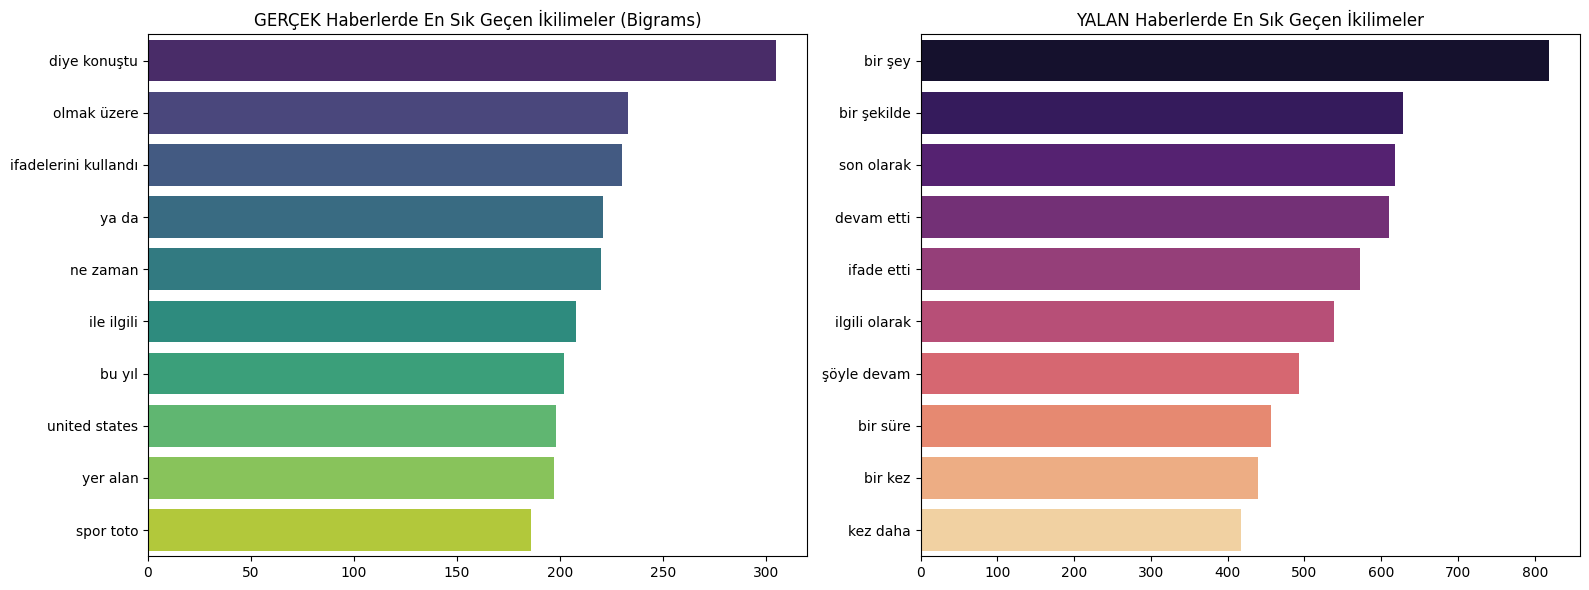


6. Violin Plot Analizi


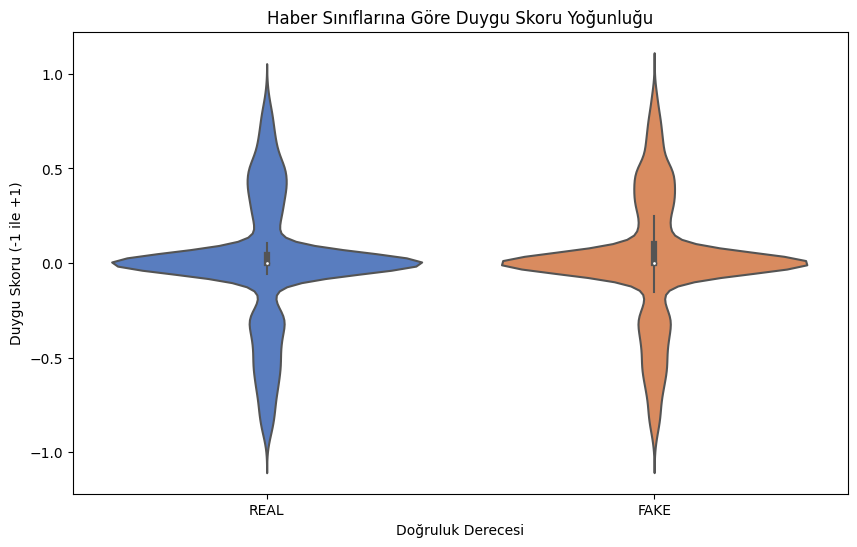

Gelişmiş analiz tamamlandı ve kaydedildi.


In [4]:
!pip install wordcloud

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

print("\n 1. Veri Kalitesi Kontrolü")
missing_values = df_master.isnull().sum()
duplicates = df_master.duplicated(subset=['text']).sum()
class_balance = df_master['label'].value_counts(normalize=True)

print(f"Eksik Veri Sayısı:\n{missing_values}")
print(f"\nTekrar Eden Satır Sayısı: {duplicates}")
print(f"\nSınıf Dağılımı (Balance):\n{class_balance}")

plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df_master, palette='viridis')
plt.title("Dataset Sınıf Dağılımı (REAL vs FAKE)")
plt.show()

len_before = len(df_master)
print(f"\nTemizlik Öncesi Toplam Satır: {len_before}")

df_master = df_master.drop_duplicates(subset=['text'], keep='first').reset_index(drop=True)

len_after = len(df_master)
deleted_count = len_before - len_after

print(f"Temizlik Sonrası Toplam Satır: {len_after}")
print(f"{deleted_count} adet kopya (duplicate) veri temizlendi.")

print("\nYeni Sınıf Dağılımı:")
print(df_master['label'].value_counts(normalize=True))


print("\n 3. Kelime Bulutu Analizi")


tr_stopwords = {
    've', 'bir', 'bu', 'da', 'de', 'için', 'ile', 'o', 'şu', 'kadar',
    'gibi', 'daha', 'en', 'mi', 'mu', 'mü', 'ama', 'fakat', 'lakin',
    'çok', 'olan', 'olarak', 'tarafından', 'sonra', 'kendi', 'bunun',
    'veya', 'diye', 'yok', 'var', 'ne', 'her', 'ise', 'ki', 'bile',
    'zaten', 'yani', 'ancak', 'çünkü', 'böyle', 'öyle', 'neden',
    'şimdi', 'nasıl', 'zaman', 'yer', 'tüm', 'bütün', 'ben', 'sen', 'bi', 'şey'
}

en_stopwords = set(STOPWORDS)
en_stopwords.update(["said", "will", "one", "also", "new", "year", "people", "us", "would", "could"])

def generate_wordcloud(df, language, label, stopwords, ax, title):

    subset = df[(df['language'] == language) & (df['label'] == label)]
    
    if len(subset) == 0:
        ax.text(0.5, 0.5, "Veri Yok", ha='center', va='center')
        ax.axis('off')
        return

    
    text_data = " ".join(subset['cleaned_text'].astype(str))
    
   
    wc = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        stopwords=stopwords, 
        max_words=100,
        min_font_size=10
    ).generate(text_data)
    

    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title, fontsize=14)


fig, axes = plt.subplots(2, 2, figsize=(18, 10))


generate_wordcloud(df_master, 'tr', 'FAKE', tr_stopwords, axes[0, 0], 'TÜRKÇE - YALAN Haberler')
generate_wordcloud(df_master, 'tr', 'REAL', tr_stopwords, axes[0, 1], 'TÜRKÇE - GERÇEK Haberler')


generate_wordcloud(df_master, 'en', 'FAKE', en_stopwords, axes[1, 0], 'ENGLISH - FAKE News')
generate_wordcloud(df_master, 'en', 'REAL', en_stopwords, axes[1, 1], 'ENGLISH - REAL News')

plt.tight_layout()
plt.show()


print("\n 4. Özellik Dağılım Analizi (KDE)")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(data=df_master, x='word_count', hue='label', fill=True, ax=axes[0])
axes[0].set_title("Kelime Sayısı Dağılımı")
axes[0].set_xlim(0, 100) 


sns.kdeplot(data=df_master, x='sentiment_score', hue='label', fill=True, ax=axes[1])
axes[1].set_title("Duygu Skoru Dağılımı (-1 Negatif, +1 Pozitif)")

plt.tight_layout()
plt.show()

print("\n 5. N-Gram (İkili Kelime) Analizi")

def get_top_n_bigrams(corpus, n=10):
   
    if corpus.empty:
        return []
        
    try:
        vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]
    except ValueError: 
        return []

common_real = get_top_n_bigrams(df_master[df_master['label']=='REAL']['cleaned_text'], 10)
common_fake = get_top_n_bigrams(df_master[df_master['label']=='FAKE']['cleaned_text'], 10)

if common_real and common_fake:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.barplot(x=[x[1] for x in common_real], y=[x[0] for x in common_real], ax=axes[0], palette='viridis')
    axes[0].set_title('GERÇEK Haberlerde En Sık Geçen İkilimeler (Bigrams)')

    sns.barplot(x=[x[1] for x in common_fake], y=[x[0] for x in common_fake], ax=axes[1], palette='magma')
    axes[1].set_title('YALAN Haberlerde En Sık Geçen İkilimeler')

    plt.tight_layout()
    plt.show()
else:
    print("Yeterli veri olmadığı için Bigram analizi çizilemedi.")


print("\n6. Violin Plot Analizi")

if 'sentiment_score' in df_master.columns:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='label', y='sentiment_score', data=df_master, order=['REAL', 'FAKE'], palette='muted')
    plt.title('Haber Sınıflarına Göre Duygu Skoru Yoğunluğu')
    plt.xlabel('Doğruluk Derecesi')
    plt.ylabel('Duygu Skoru (-1 ile +1)')
    plt.show()

df_master.to_csv("Phase1_Final_Enhanced.csv", index=False)
print("Gelişmiş analiz tamamlandı ve kaydedildi.")


 Derinlemesine Dil Analizi (Readability)
Okunabilirlik Skorları (Yüksek Puan = Daha Basit Dil):
label
FAKE   -64.680069
REAL    -3.052115
Name: readability_score, dtype: float64


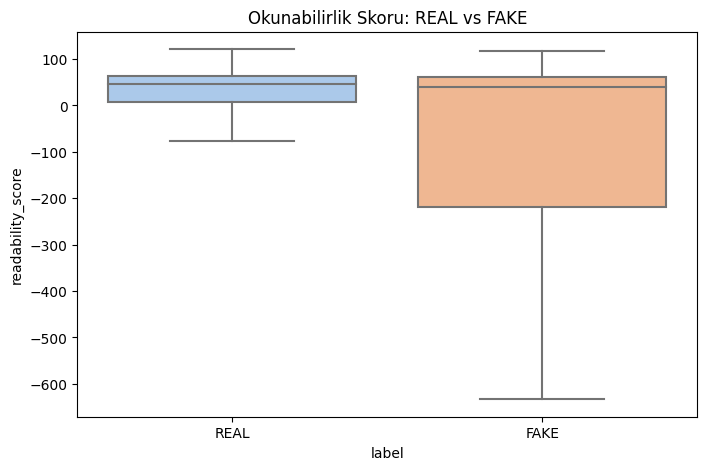


 5. Kaynak Güvenilirlik Skoru
Güvenilirlik Skorları:
label           source  Trust_Score
0           Reddit_RSS    73.195876
1         LIAR_Dataset    56.187029
2      Turkish_Dataset    51.460018

JSON Hazırlığı
'news_data_for_app.json' dosyası başarıyla oluşturuldu.
Tüm işlemler tamamlandı. Dosya kaydedildi.


In [5]:
!pip install textstat

import textstat
import json

print("\n Derinlemesine Dil Analizi (Readability)")


def get_readability(text):
    return textstat.flesch_reading_ease(str(text))

df_master['readability_score'] = df_master['text'].apply(get_readability)


readability_stats = df_master.groupby('label')['readability_score'].mean()
print("Okunabilirlik Skorları (Yüksek Puan = Daha Basit Dil):")
print(readability_stats)


plt.figure(figsize=(8, 5))
sns.boxplot(x='label', y='readability_score', data=df_master, showfliers=False, palette='pastel')
plt.title("Okunabilirlik Skoru: REAL vs FAKE")
plt.show()


print("\n 5. Kaynak Güvenilirlik Skoru")


source_reliability = df_master.groupby('source')['label'].value_counts(normalize=True).unstack().fillna(0)

if 'REAL' in source_reliability.columns:
    source_reliability['Trust_Score'] = source_reliability['REAL'] * 100
else:
    source_reliability['Trust_Score'] = 0

trust_scores = source_reliability[['Trust_Score']].sort_values(by='Trust_Score', ascending=False).reset_index()

print("Güvenilirlik Skorları:")
print(trust_scores.head())


df_master = df_master.merge(trust_scores, on='source', how='left')



print("\nJSON Hazırlığı")


if 'readability_score' not in df_master.columns:
    df_master['readability_score'] = df_master['text'].apply(lambda x: textstat.flesch_reading_ease(str(x)))


app_data = df_master[['text', 'label', 'Trust_Score', 'readability_score']].head(100).to_dict(orient='records')


with open('news_data_for_app.json', 'w', encoding='utf-8') as f:
    json.dump(app_data, f, ensure_ascii=False, indent=4)

print("'news_data_for_app.json' dosyası başarıyla oluşturuldu.")

df_master.to_csv("Phase1_Final_Ultimate.csv", index=False)
print("Tüm işlemler tamamlandı. Dosya kaydedildi.")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 requires pyOpenSSL<=24.2.1,>=19.1.0, but you have pyopenssl 25.3.0 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2025.10.0 which is incompatible.


2025-12-07 14:13:04.228868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765116784.399069      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765116784.444452      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Kurulumlar Tamamlandı. Veri Yükleniyor...

Veri Hazır: 14772 satır.

İstatistiksel Analizler...


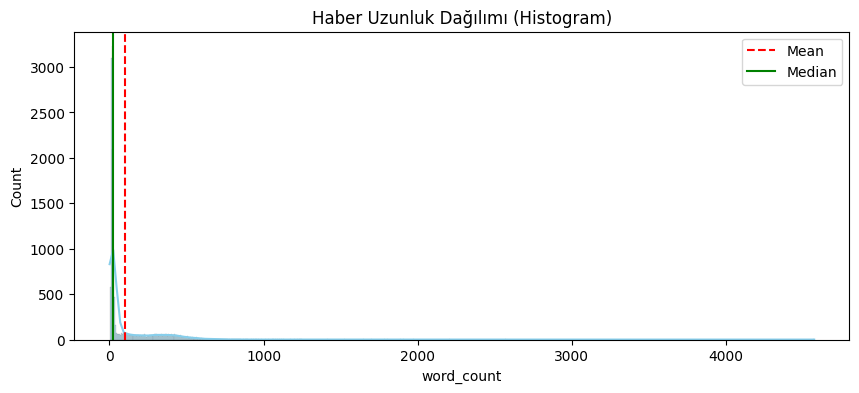

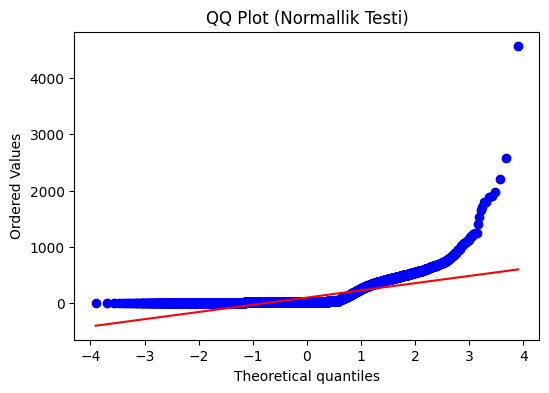


Clustering & Anomaly Detection...


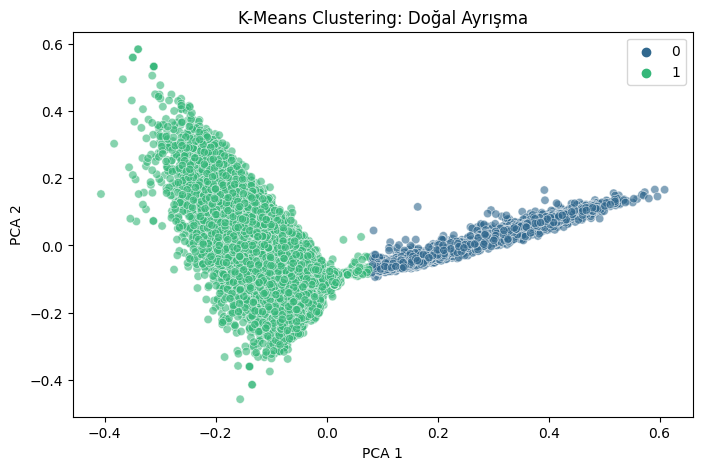


MODEL EĞİTİMİ
1️Logistic Regression (Grid Search)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Logistic Regression Accuracy: %72.32

 Deep Learning (Bi-LSTM)...
Epoch 1/5


I0000 00:00:1765116814.212248      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1765116819.086301     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


370/370 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.6127 - loss: 0.6527 - val_accuracy: 0.6998 - val_loss: 0.4985
Epoch 2/5
370/370 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.7228 - loss: 0.4779 - val_accuracy: 0.7154 - val_loss: 0.4906
Epoch 3/5
370/370 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.7614 - loss: 0.4258 - val_accuracy: 0.7052 - val_loss: 0.5016
Epoch 4/5
370/370 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.7830 - loss: 0.4087 - val_accuracy: 0.7222 - val_loss: 0.5385
Epoch 5/5
370/370 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.7989 - loss: 0.3748 - val_accuracy: 0.7178 - val_loss: 0.5521
 LSTM Accuracy: %71.78

KAZANAN MODEL ANALİZİ
KAZANAN: Logistic Regression
İkinci : LSTM
Fark   : %0.54


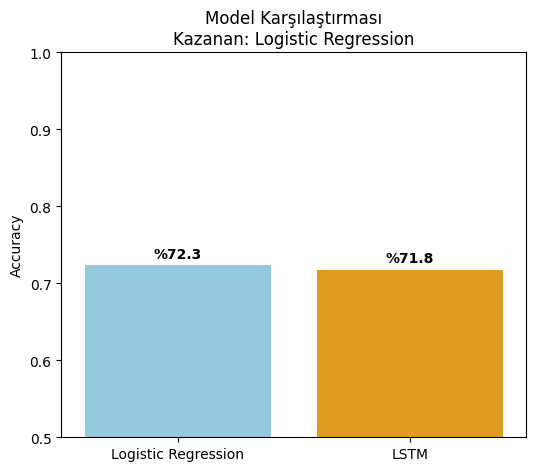


Hata Matrisi (Logistic Regression):


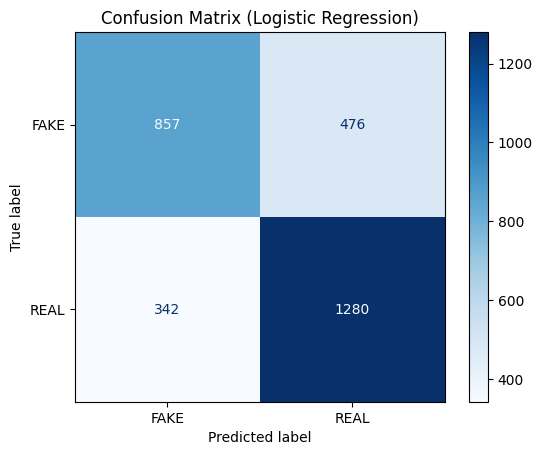


Dosyalar Kaydediliyor...


In [6]:
!pip install tensorflow scikit-learn seaborn matplotlib joblib scipy > /dev/null

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import re
import pickle
import scipy.stats as stats


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
import warnings

warnings.filterwarnings('ignore')

print("Kurulumlar Tamamlandı. Veri Yükleniyor...\n")

filename = "Phase1_Final_Ultimate.csv"

if not os.path.exists(filename):
    if os.path.exists("Phase1_Final_Ultimate.csv"):
        filename = "Phase1_Final_Ultimate.csv"
    else:
        print("Dosya bulunamadı! Demo veri (Dummy Data) oluşturuluyor...")
        
        df = pd.DataFrame({
            'text': [f'fake news sample text number {i}' for i in range(100)] + 
                    [f'real news reliable source number {i}' for i in range(100)],
            'label': ['FAKE']*100 + ['REAL']*100
        })

if os.path.exists(filename):
    df = pd.read_csv(filename)
    
    if 'label_id' not in df.columns:
        label_map = {'REAL': 1, 'FAKE': 0, 'real': 1, 'fake': 0, 'TRUE': 1, 'FALSE': 0}
        df['label_id'] = df['label'].map(label_map)
    
    if 'cleaned_text' not in df.columns:
         def simple_clean(text):
             return re.sub(r'[^a-zA-Z0-9\s]', '', str(text).lower())
         df['cleaned_text'] = df['text'].apply(simple_clean)

    df = df.dropna(subset=['cleaned_text', 'label_id'])
    

    df['word_count'] = df['cleaned_text'].apply(lambda x: len(str(x).split()))
    
    print(f"Veri Hazır: {len(df)} satır.")

print("\nİstatistiksel Analizler...")

plt.figure(figsize=(10, 4))
sns.histplot(df['word_count'], kde=True, color='skyblue')
plt.axvline(df['word_count'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(df['word_count'].median(), color='green', linestyle='-', label='Median')
plt.title('Haber Uzunluk Dağılımı (Histogram)')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
stats.probplot(df['word_count'], dist="norm", plot=plt)
plt.title('QQ Plot (Normallik Testi)')
plt.show()

print("\nClustering & Anomaly Detection...")

X_text = df['cleaned_text'].astype(str)
y = df['label_id'].astype(int)

tfidf_cluster = TfidfVectorizer(max_features=3000)
X_cluster = tfidf_cluster.fit_transform(X_text)

kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_cluster)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster.toarray())

plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette='viridis', alpha=0.6)
plt.title('K-Means Clustering: Doğal Ayrışma')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

print("\nMODEL EĞİTİMİ")

X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42, stratify=y)

print("1️Logistic Regression (Grid Search)...")
pipe_vec = TfidfVectorizer(max_features=5000, ngram_range=(1,2)) 
X_train_vec = pipe_vec.fit_transform(X_train)
X_test_vec = pipe_vec.transform(X_test)

param_grid = {'C': [0.1, 1, 10, 100], 'solver': ['liblinear']}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=3, verbose=1)
grid.fit(X_train_vec, y_train)

best_lr = grid.best_estimator_
lr_acc = accuracy_score(y_test, best_lr.predict(X_test_vec))
print(f"Logistic Regression Accuracy: %{lr_acc*100:.2f}")

print("\n Deep Learning (Bi-LSTM)...")
max_words = 10000
max_len = 150

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    LSTM(32), 
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_seq, y_train, epochs=5, batch_size=32, validation_data=(X_test_seq, y_test), verbose=1)

lstm_loss, lstm_acc = model.evaluate(X_test_seq, y_test, verbose=0)
print(f" LSTM Accuracy: %{lstm_acc*100:.2f}")


print("\n" + "="*40)
print("KAZANAN MODEL ANALİZİ")
print("="*40)

diff = abs(lr_acc - lstm_acc) * 100

if lr_acc > lstm_acc:
    winner = "Logistic Regression"
    print(f"KAZANAN: {winner}")
    print(f"İkinci : LSTM")
    print(f"Fark   : %{diff:.2f}")
   
else:
    winner = "LSTM (Deep Learning)"
    print(f" KAZANAN: {winner}")
    print(f"İkinci : Logistic Regression")
    print(f" Fark   : %{diff:.2f}")
    

plt.figure(figsize=(6, 5))
sns.barplot(x=['Logistic Regression', 'LSTM'], y=[lr_acc, lstm_acc], palette=['skyblue', 'orange'])
plt.ylim(0.5, 1.0)
plt.title(f'Model Karşılaştırması\nKazanan: {winner}')
plt.ylabel('Accuracy')
for i, v in enumerate([lr_acc, lstm_acc]):
    plt.text(i, v + 0.01, f"%{v*100:.1f}", ha='center', fontweight='bold')
plt.show()

print(f"\nHata Matrisi ({winner}):")
if winner == "Logistic Regression":
    y_pred = best_lr.predict(X_test_vec)
else:
    y_pred = (model.predict(X_test_seq) > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FAKE', 'REAL'])
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix ({winner})')
plt.show()

print("\nDosyalar Kaydediliyor...")
model.save("fake_news_binary_lstm.keras")
joblib.dump(best_lr, "fake_news_binary_logreg.pkl")

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
